# Welcome to VoxelNet & 3D CNNs Workshop!
In this workshop, we're going to learn how to voxelize a point cloud, and build a 3D Convolutional Neural Network to classify point clouds. When processing point clouds, voxel based approaches account for a good half of the existing approaches (with point based approaches being the second half) — and it's therefore important to understand how to implement them!
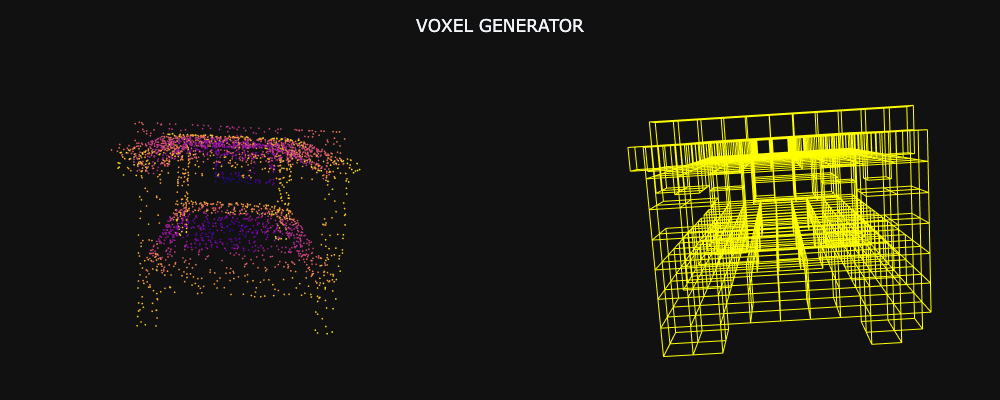

## Imports
For voxelization, we're going to reuse the SPConv Library, which can also handle sparse convolutions. You usually want to install it using PIP, and you want to install the version linked to your Nvidia GPU. If you're on CUDA 11.4, you're using SPCONV-CU114; etc...

In [ ]:
#!pip install --quiet spconv-cu114 SharedArray

In [ ]:
# Usual Imports
import os
import sys
import json
import numpy as np
from tqdm import tqdm
import cumm.tensorview as tv  # CUDA Matrix multiplication library
import spconv                 # Sparse convolution library

# plotting library
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# append path to custom scripts
sys.path.append('/kaggle/input/d/jeremy26/lidar-od-scripts/gpuVersion/gpuVersion/')

# DL Imports
import torch

# custom imports
import common_utils
from visual_utils import plot_pc_data3d, plot_bboxes_3d

In [ ]:
DATA_FOLDER = '/kaggle/input/shapenet-core/Shapenetcore_benchmark/'

class_name_id_map = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

class_id_name_map = {v:k for k,v in class_name_id_map.items()}

PCD_SCENE=dict(xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False), aspectmode='data')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Shapenet Core Dataset exploration

- Object Classification and part Segmentation Dataset from Point Cloud data
- [Shapenet core](https://shapenet.org/) is a subset of the full ShapeNet dataset 
- It contains single clean 3D models, manually verified category and alignment annotations. 
- 16 classes from 12 categories

In [ ]:
train_split_data = json.load(open('/kaggle/input/shapenet-core/Shapenetcore_benchmark/train_split.json', 'r'))
train_class_count = np.array([x[0] for x in train_split_data])

# plot classwise count in train set
train_dist_plots = [go.Bar(x=list(class_name_id_map.keys()), y= np.bincount(train_class_count))]
layout = dict(template="plotly_dark", title="Shapenet Core Train Distribution", title_x=0.5)
fig = go.Figure(data=train_dist_plots, layout=layout)   
fig.show()

In [ ]:
import glob
points_list = glob.glob("/kaggle/input/shapenet-core/Shapenetcore_benchmark/04379243/points/*.npy")
print(len(points_list))

In [ ]:
import random
idx = random.randint(0,len(points_list))
points = np.load(points_list[idx])
print(f"points shape = {points.shape}, min xyz = {np.min(points, axis=0)}, max xyz = {np.max(points, axis=0)}")

In [ ]:
print(points)

In [ ]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2])
layout = dict(template="plotly_dark", title="Raw Point cloud", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

## Voxel Generation
We're now going to reuse what we did in Voxel Generation to create voxels; and we'll add something to visualize them in 3D.

In [ ]:
from spconv.utils import Point2VoxelCPU3d

vsize_xyz = np.array([0.05, 0.05, 0.05])
max_num_voxels = 2000
max_num_points_per_voxel = 25

coors_range_xyz = np.array([-0.5, -0.5, -0.5, 0.5, 0.5, 0.5])

class Voxel_Generator:
    def __init__(self):
        self.point_to_voxel_converter = Point2VoxelCPU3d(
                vsize_xyz = vsize_xyz,  # voxel size in x,y,z (metres) 
                coors_range_xyz = coors_range_xyz,  # point cloud range - unit cube size
                num_point_features = 3,  # x,y,z 
                max_num_points_per_voxel = max_num_points_per_voxel,
                max_num_voxels= max_num_voxels,
                )
    
    def generate_voxels(self, points):
        # generate voxels from point cloud data
        tv_voxels, tv_voxel_indices, tv_num_points = self.point_to_voxel_converter.point_to_voxel(tv.from_numpy(points))

        # make copy with numpy(), since numpy_view() will disappear as soon as the generator is deleted
        voxels = tv_voxels.numpy()
        voxel_indices = tv_voxel_indices.numpy()
        num_points = tv_num_points.numpy()
        return voxels, voxel_indices, num_points

In [ ]:
voxel_converter = Voxel_Generator()

voxels, voxel_indices, num_points = voxel_converter.generate_voxels(points)
print(f"points.shape = {points.shape}")
print(f"voxels.shape = {voxels.shape}")
print(f"voxel_indices.shape = {voxel_indices.shape}")
print(f"num_points.shape = {num_points.shape}")

In [ ]:
print(num_points)

### Voxel visualization

In [ ]:
from visual_utils import boxes_to_corners_3d

def get_voxel_corners(voxel_indices, voxel_size, pc_range):
    # converting grid indices to actual 3D coordinates
    # indices give bottom left corner, add half voxel size to get voxel centres
    voxel_centres = (voxel_indices[:, ::-1] * voxel_size) + pc_range[0:3] + (voxel_size * 0.5)

    # Changing to [x,y,z,dx,dy,dz,yaw] format to find voxel corners
    voxel_bboxes = np.column_stack((voxel_centres, np.repeat( np.append(voxel_size, 0.0)[None,:], len(voxel_indices), axis=0)))
    voxel_corners = boxes_to_corners_3d(voxel_bboxes)
    return voxel_corners

In [ ]:
voxel_corners = get_voxel_corners(voxel_indices, voxel_size=vsize_xyz, pc_range=coors_range_xyz)
voxel_generator_plots = plot_bboxes_3d(voxel_corners, box_colors=['white'] * len(voxel_corners))

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]])
fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 400, width = 1000,
                title=f"VOXEL GENERATOR", title_x=0.5, title_y=0.95, margin=dict(r=0, b=0, l=0, t=0))    

fig.add_trace(pc_plots, row=1, col=1)
for trace in voxel_generator_plots:        
    fig.add_trace(trace, row=1, col=2)
fig.show()  

## Build a Custom Dataset
Now that we've explored our data, and seen how to voxelize a point cloud, we'll get more 'PyTorch friendly' and create a Dataset object, as well as a PyTorch Dataloader.

In [ ]:
class ShapeNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split_type):
        self.root_dir = root_dir
        self.split_type = split_type
        with open(os.path.join(root_dir, f'{self.split_type}_split.json'), 'r') as f:
            self.split_data = json.load(f)       
        
        # create voxel converter object
        self.voxel_converter = Voxel_Generator()
    
    def __getitem__(self, index):
        # read point cloud data
        class_id, class_name, point_cloud_path = self.split_data[index]        
        point_cloud_path = os.path.join(self.root_dir, point_cloud_path)
        pc_data = np.load(point_cloud_path)
        
        # generate voxels from point cloud
        voxels, voxel_indices, num_points = self.voxel_converter.generate_voxels(pc_data)

        # return variable
        data_dict= {}
        data_dict['points'] = pc_data 
        data_dict['num_points'] = pc_data.shape[0]
        data_dict['voxels'] = voxels
        data_dict['num_voxels'] = voxels.shape[0]
        data_dict['voxel_coords'] = voxel_indices
        data_dict['voxel_num_points'] = num_points        
        data_dict['class_id'] = class_id
        data_dict['class_name'] = class_name
        return data_dict        
    
    @staticmethod
    def collate_batch(batch_list, _unused=False):
        ret = {}
        ret['class_id'] = np.array([x['class_id'] for x in batch_list])
        ret['class_name'] = np.array([x['class_name'] for x in batch_list])
        ret['num_points'] = np.array([x['num_points'] for x in batch_list])
        ret['num_voxels'] = np.array([x['num_voxels'] for x in batch_list])
        ret['voxels'] = np.concatenate([x['voxels'] for x in batch_list], axis=0)
        ret['voxel_num_points'] = np.concatenate([x['voxel_num_points'] for x in batch_list], axis=0)
        
        for key in ['points', 'voxel_coords']:
            val = [x[key] for x in batch_list]
            coors = []
            for i, coor in enumerate(val):
                coor_pad = np.pad(coor, ((0, 0), (1, 0)), mode='constant', constant_values=i)
                coors.append(coor_pad)
            ret[key] = np.concatenate(coors, axis=0)
        ret['batch_size'] = len(batch_list)
        return ret
                    
    def __len__(self):
        return len(self.split_data)

In [ ]:
train_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='train')
val_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='val')
test_set = ShapeNetDataset(root_dir = DATA_FOLDER, split_type='test')
print(f"Train set length = {len(train_set)}")
print(f"Validation set length = {len(val_set)}")
print(f"Test set length = {len(test_set)}")

In [ ]:
data_dict= train_set[25]
print(f"Keys in dataset sample = {list(data_dict.keys())}")
points = data_dict['points']
voxel_indices = data_dict['voxel_coords']
print(f"class_id = {data_dict['class_id']}, class_name = {data_dict['class_name']}")

In [ ]:
pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2])
voxel_corners = get_voxel_corners(voxel_indices, voxel_size=vsize_xyz, pc_range=coors_range_xyz)
voxel_generator_plots = plot_bboxes_3d(voxel_corners, box_colors=['white'] * len(voxel_corners))

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]])
fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 400, width = 1000,
                title=f"TRAINING DATASET SAMPLE", title_x=0.5, title_y=0.95, margin=dict(r=0, b=0, l=0, t=0))    

fig.add_trace(pc_plots, row=1, col=1)
for trace in voxel_generator_plots:        
    fig.add_trace(trace, row=1, col=2)
fig.show()  

### Data loader for Custom dataset

In [ ]:
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=8, num_workers=2, shuffle=True, collate_fn=ShapeNetDataset.collate_batch) 
dataloader_iter = iter(sample_loader)   
batch_dict = next(dataloader_iter)

def load_data_to_gpu(batch_dict):
    # Labels from np arrays -> torch tensor -> GPU
    batch_dict['class_id'] = torch.from_numpy(batch_dict['class_id']).long().cuda()
    
    # voxel params from np arrays -> torch tensor -> GPU
    for key in ['voxels', 'voxel_num_points', 'voxel_coords']:
        batch_dict[key] = torch.from_numpy(batch_dict[key]).float().cuda()    
        
load_data_to_gpu(batch_dict)   
print(batch_dict.keys())

In [ ]:
batch_dict['class_id'], batch_dict['class_name']
print(f"batch_dict['voxels'].shape = {batch_dict['voxels'].shape}")
print(f"batch_dict['voxel_num_points'].shape = {batch_dict['voxel_num_points'].shape}")
print(f"batch_dict['voxel_coords'].shape = {batch_dict['voxel_coords'].shape}")
print(f"batch_dict['class_id'].shape = {batch_dict['class_id'].shape}")

## Model Architecture

Model Architecture consists of 3 main components
1. Voxel Feature Encoding
2. 3D CNN (Voxel Feature Extraction)
3. Classification

### 1. Voxel Feature Encoding
**VFE (Voxel Feature Encoding) is NOT Voxelization**. Voxelization is converting a set of points into voxels. VFE is what you do after you have this. It's usually about aggregating the features (position, color, intensity) inside each voxel. This aggregation can be done in various ways, such as taking the mean, maximum, or concatenating the features.

By applying meanVFE, **the dimensionality of the point cloud data is reduced**, which can lead to more efficient processing and analysis. It also provides a way to capture local information within a voxel while preserving the overall structure of the point cloud.

In [ ]:
import torch.nn as nn

class MeanVFE(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, batch_dict):
        """
        Args:
            batch_dict:
                voxels: (num_voxels, max_points_per_voxel, C)
                voxel_num_points: (num_voxels)
        Returns:
            vfe_features: (num_voxels, C)
        """
        voxel_features, voxel_num_points = batch_dict['voxels'], batch_dict['voxel_num_points']
        points_mean = voxel_features[:, :, :].sum(dim=1, keepdim=False)
        normalizer = torch.clamp_min(voxel_num_points.view(-1, 1), min=1.0).type_as(voxel_features)
        points_mean = points_mean / normalizer
        batch_dict['voxel_features'] = points_mean.contiguous()
        return batch_dict

In [ ]:
voxel_feature_encoder = MeanVFE()
batch_dict = voxel_feature_encoder(batch_dict)
print(batch_dict["voxels"][0])
print(batch_dict["voxel_features"][0])

print(f"batch_dict['voxel_features'].shape = {batch_dict['voxel_features'].shape}")

### 2. Voxel Feature Extraction with 3D CNNs!
So we've encoded voxels and we have data to process. We can now run **3D Convolutions**! And because we have Sparse Data, we'll use **Sparse Convolutions**!
Taken from the PV-RCNN paper, these are the steps we'll implement:

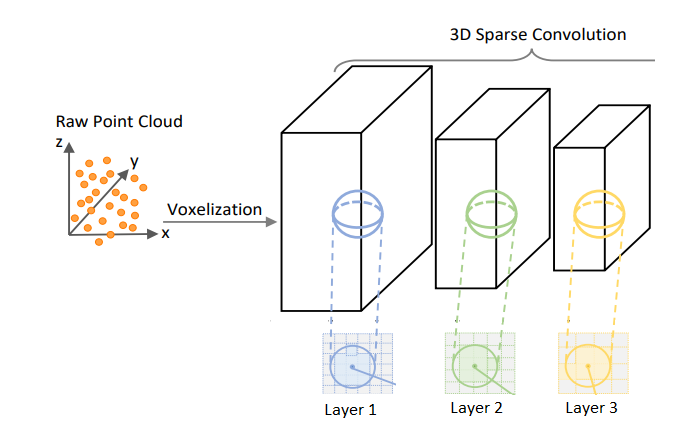

**Sparse vs Submanifold Convolutions**: As explained in the course, we may want to use both Sparse and Submanifold convolutions, and this is what the VoxelNet architecture is often doing. So we'll implement a system to use them both.

In [ ]:
from functools import partial
from spconv_utils import spconv

def post_act_block(in_channels, out_channels, kernel_size, indice_key=None, stride=1, padding=0,
                   conv_type='subm', norm_fn=None):
    if conv_type == 'subm':
        conv = spconv.SubMConv3d(in_channels, out_channels, kernel_size, bias=False, indice_key=indice_key)
    elif conv_type == 'spconv':
        conv = spconv.SparseConv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                                   bias=False, indice_key=indice_key)
    m = spconv.SparseSequential(conv, norm_fn(out_channels), nn.ReLU())
    return m 


class Voxel_Feature_Extractor(nn.Module):
    def __init__(self, input_channels, grid_size):
        super().__init__()
        norm_fn = partial(nn.BatchNorm1d, eps=1e-3, momentum=0.01)
        self.sparse_shape = grid_size[::-1] + [1, 0, 0]
        
        self.conv_input = spconv.SparseSequential(
            spconv.SubMConv3d(input_channels, 16, 3, padding=1, bias=False, indice_key='subm1'),
            norm_fn(16),
            nn.ReLU(),
        )
        block = post_act_block

        self.conv1 = spconv.SparseSequential(
            block(16, 16, 3, norm_fn=norm_fn, padding=1, indice_key='subm1'),
        )

        self.conv2 = spconv.SparseSequential(
            block(16, 32, 3, norm_fn=norm_fn, stride=2, padding=1, indice_key='spconv2', conv_type='spconv'),
            block(32, 32, 3, norm_fn=norm_fn, padding=1, indice_key='subm2'),
            block(32, 32, 3, norm_fn=norm_fn, padding=1, indice_key='subm2'),
        )

        self.conv3 = spconv.SparseSequential(
            block(32, 64, 3, norm_fn=norm_fn, stride=2, padding=1, indice_key='spconv3', conv_type='spconv'),
            block(64, 64, 3, norm_fn=norm_fn, padding=1, indice_key='subm3'),
            block(64, 64, 3, norm_fn=norm_fn, padding=1, indice_key='subm3'),
        )

        self.conv_out = spconv.SparseSequential(
            spconv.SparseConv3d(64, 128, (3, 1, 1), stride=(2, 1, 1), padding=0,
                                bias=False, indice_key='spconv_down2'),
            norm_fn(128),
            nn.ReLU(),
        )


    def forward(self, batch_dict):
        """
        Args:
            batch_dict:
                batch_size: int
                voxel_features: (num_voxels, C)
                voxel_coords  : (num_voxels, 4), [batch_idx, z_idx, y_idx, x_idx]
        Returns:
            batch_dict:
                encoded_spconv_tensor: sparse tensor
        """
        # convert voxel features to sparse tensor in mentioned grid size        
        voxel_features, voxel_coords = batch_dict['voxel_features'], batch_dict['voxel_coords']
        input_sp_tensor = spconv.SparseConvTensor(
            features=voxel_features,
            indices=voxel_coords.int(),
            spatial_shape=self.sparse_shape,
            batch_size=batch_dict['batch_size']
        )
        
        x = self.conv_input(input_sp_tensor)
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        x_conv3 = self.conv3(x_conv2)
        out = self.conv_out(x_conv3)
        
        # store output
        batch_dict['x_conv1'] = x_conv1
        batch_dict['x_conv2'] = x_conv2
        batch_dict['x_conv3'] = x_conv3        
        batch_dict['encoded_spconv_tensor'] = out
        return batch_dict

In [ ]:
voxel_feature_extractor = Voxel_Feature_Extractor(input_channels=3, grid_size=np.array([20, 20, 20]))
voxel_feature_extractor.to(device);
batch_dict = voxel_feature_extractor(batch_dict)

### 3. Classification head
Finally, we'll create a set of linear layers to classify our input. As a reminder, the ShapeNet Dataset has 16 classes.

In [ ]:
import torch.nn.functional as F

class Classifier_Head(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.fc1 = nn.Linear(256 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self.num_classes)
    
    def forward(self, batch_dict):
        """
        Args:
            batch_dict:
                encoded_spconv_tensor: sparse tensor
        Returns:
            batch_dict:
                spatial_features:
        """
        bs = batch_dict['batch_size']
        flattened_features = batch_dict['encoded_spconv_tensor'].dense().view(bs, -1)
        x = F.relu(self.fc1(flattened_features))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        batch_dict['fc_out'] = x
        return batch_dict

In [ ]:
classifier_head = Classifier_Head(num_classes =16)
classifier_head.to(device);
batch_dict = classifier_head(batch_dict)

In [ ]:
print(batch_dict["fc_out"][0])

## Putting it all together
We'll create a End-to-End model that takes in Point cloud as input, extract features from it and predict the class

In [ ]:
class Point_Cloud_Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.feature_encoder = MeanVFE()
        self.feature_extractor = Voxel_Feature_Extractor(input_channels=3, grid_size=np.array([20, 20, 20]))
        self.head = Classifier_Head(num_classes = self.num_classes)
        
    def forward(self, batch_dict):
        batch_dict = self.feature_encoder(batch_dict)
        batch_dict = self.feature_extractor(batch_dict)
        batch_dict = self.head(batch_dict)
        return batch_dict

## Training & validation loop

#### Loss function
- As this is a classification task, we will use `Cross Entropy` as loss function 

#### Training strategy
- We will train the model on the training set, evaluate the loss on validation set and select the model lowest validation loss to be evaluated on the test set

#### Evaluation metrics
- Classification metrics like `Accuracy, Confusion Matrix`

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix 

class Classification_Metric:
    def __init__(self, num_classes):
        self.all_preds = []
        self.all_labels = []
        self.num_classes = num_classes
        self.reset_metrics()

    def update(self, y_preds, labels):
        predicted_labels = torch.argmax(y_preds, dim=1)
        self.all_preds.extend(predicted_labels.numpy().flatten().tolist())
        self.all_labels.extend(labels.numpy().flatten().tolist())        
    
    def compute_accuracy(self):
        self.accuracy = accuracy_score(self.all_labels, self.all_preds)

    def compute_confusion_matrix(self):
        self.confusion_matrix = confusion_matrix(self.all_labels, self.all_preds)
    
    def compute(self):
        self.compute_accuracy()
        self.compute_confusion_matrix()
        return self.accuracy
    
    def reset_metrics(self):
        self.accuracy = 0.0
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

In [ ]:
import pandas as pd

def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

In [ ]:
def evaluate_model(model, dataloader, criterion, metric_class, num_classes, device):
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(num_classes)

    with torch.no_grad():
        for batch_dict in tqdm(dataloader, total=len(dataloader)):
            load_data_to_gpu(batch_dict)
            pred_dict = model(batch_dict)

            # calculate loss
            loss = criterion(pred_dict['fc_out'], batch_dict['class_id'])
            total_loss += loss.item()

            # update batch metric information
            metric_object.update(pred_dict['fc_out'].cpu().detach(), batch_dict['class_id'].cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric, metric_object

In [ ]:
def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, num_classes, lr_scheduler = None,
                         output_path = '.'):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for batch_dict in tqdm(dataloader_train, total=len(dataloader_train)):
            load_data_to_gpu(batch_dict)
            
            # Forward pass
            pred_dict = model(batch_dict)
            loss = criterion(pred_dict['fc_out'], batch_dict['class_id'])
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric, _ = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, num_classes, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 
                        'trainLoss': train_loss, 
                        'validationLoss': validation_loss, 
                        f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{output_path}/{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, num_workers=2, shuffle=True, collate_fn=ShapeNetDataset.collate_batch) 
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, num_workers=2, shuffle=False, collate_fn=ShapeNetDataset.collate_batch)    
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, num_workers=2, shuffle=False, collate_fn=ShapeNetDataset.collate_batch) 

In [ ]:
# MODEL HYPERPARAMETERS
N_EPOCHS = 3
MAX_LR = 3e-4
NUM_CLASSES = 16
MODEL_NAME = 'Point_Cloud_Classifier'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = nn.CrossEntropyLoss()

# create model, optimizer, lr_scheduler and pass to training function
model = Point_Cloud_Classifier(num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_loader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_loader, val_loader, Classification_Metric, 'Accuracy',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = '.')

## Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{MODEL_NAME}.pt', map_location=device))
_, test_accuracy, test_metric_obj  = evaluate_model(model, test_loader, criterion, Classification_Metric, NUM_CLASSES, device)
print(f"\nModel has {test_accuracy * 100.0 : .2f}% Accuracy in test set")

Let's compare how model performs across different classes using `Confusion Matrix`

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(test_metric_obj.confusion_matrix, classes= list(class_name_id_map.keys()), normalize=True)

## BONUS: Visualize Extracted features
- We'll try to visualize the activations from 1st Sparse convolution layer
- As with dense convolution, initial layers have shown to learn simpler features like edges, corners etc, while later layers have more abstract features

In [ ]:
# Select a random sample -> Forward pass -> model predictions
test_sample = test_set[np.random.choice(np.arange(len(test_set)))]
batch_dict = ShapeNetDataset.collate_batch([test_sample])
load_data_to_gpu(batch_dict)
model_preds = model(batch_dict)

predicted_class = torch.argmax(model_preds['fc_out'], axis=1).detach().cpu().numpy()[0]
predicted_class_name = class_id_name_map[predicted_class]
pred_class_probs = F.softmax(model_preds['fc_out'].flatten(), dim=None).detach().cpu().numpy()

In [ ]:
sp_conv1_feature_map = model_preds['x_conv1'].dense().detach().cpu().numpy()
print(f"sp_conv1 output shape = {sp_conv1_feature_map.shape}")

# We'll reshape the feature map to a 3D volume for easy visualization
sp_conv1_feature_map = sp_conv1_feature_map.reshape(-1, 20, 20)
print(f"After reshaping, sp_conv1 output shape = {sp_conv1_feature_map.shape}")

- We'll slice through each of the layers of the 3D volume and plot each level sequentially
- Since Voxels are sparse in nature, number of these layers can be empty -> Need some filtering on selecting channels to plot from feature map volume

In [ ]:
def filter_feature_map(feature, threshold = 0.02):
    output = []
    c, h, w = feature.shape
    max_area = h * w
    for i in range(c):
        num_nonzero_pixels = float(np.nonzero(feature[i])[0].size)
        if((num_nonzero_pixels / max_area ) > threshold):
            output.append(feature[i])
    return np.stack(output)

A Matplotlib plotter class that animates and saves the different layers of feature maps to `gif` format

In [ ]:
import cv2

class ImageToGIF:
    def __init__(self, size=(300, 300), dpi=100, cmap='inferno', fig_title=''):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / dpi, size[1] / dpi)
        self.cmap = cmap
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.images = []
        plt.suptitle(fig_title, color='white')
 
    def add(self, image, with_mask=False):
        plt.set_cmap(self.cmap)        
        smoothed_image =  cv2.GaussianBlur(cv2.resize(image, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC), (3,3), 0)
        plt_img = self.ax.imshow(smoothed_image, animated=True)
        to_plot = [plt_img]
        self.images.append(to_plot)
        plt.close()
 
    def save(self, filename, fps):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps=fps)

In [ ]:
import matplotlib.animation as anim
from IPython.display import Image as show_gif

model_output_gif = ImageToGIF(fig_title='SP Conv1 features')
filename = f'{predicted_class_name}_spconv1_feature_map.gif'

for i in tqdm(range(sp_conv1_feature_map.shape[0])):
    model_output_gif.add(sp_conv1_feature_map[i])

model_output_gif.save(filename, fps=10) 

In [ ]:
points = test_sample['points']
voxel_indices = test_sample['voxel_coords']

pc_plots = plot_pc_data3d(x=points[:,0], y=points[:,1], z=points[:,2])
voxel_corners = get_voxel_corners(voxel_indices, voxel_size=vsize_xyz, pc_range=coors_range_xyz)
voxel_generator_plots = plot_bboxes_3d(voxel_corners, box_colors=['white'] * len(voxel_corners))
title = f"Label = {test_sample['class_name']}, Predicted class = {predicted_class_name}"


fig = make_subplots(rows=1, cols=3, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {}]], column_widths=[0.35, 0.35, 0.4])
fig.update_layout(template="plotly_dark", scene=PCD_SCENE, scene2=PCD_SCENE, height = 400, width = 1200,
                title=title, title_x=0.5, title_y=0.95, margin=dict(r=0, b=0, l=0, t=0))    

fig.add_trace(pc_plots, row=1, col=1)
for trace in voxel_generator_plots:        
    fig.add_trace(trace, row=1, col=2)
fig.add_trace(go.Bar(x=list(class_name_id_map.keys()), y=pred_class_probs, showlegend=False), row=1, col=3)

fig.show()
show_gif(filename, format='png')